![logo](./img/LogoLine_horizon_CAMS.png)

<br>

# Access and Visualisation of CAMS Ozone Data
In this tutorial we will access and view reanalysis data of total column ozone from the Atmosphere Data Store (ADS) of the Copernicus Atmosphere Monitoring Service (CAMS).

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/CAMS_ozone.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/CAMS_ozone.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/CAMS_ozone.ipynb)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/CAMS_ozone.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install [Xarray](http://xarray.pydata.org/en/stable/) for working with multidimensional data in netcdf files, and the ADS API (`pip install cdsapi`) for downloading data programatically from the ADS.

### Register with ADS and obtain ADS API key

Before you can request data from the ADS, you will need to register on the ADS website (https://ads.atmosphere.copernicus.eu/). To download data programmatically (using the API, and not just the web interface), you will need to obtain an API Key. In order to do so, please follow the steps at this link: https://ads.atmosphere.copernicus.eu/api-how-to

Once you have an API Key for the ADS, insert it into the cell below, i.e. substitute `ADS_API_KEY` with your ADS API key, then click "Run", or select Shift+Enter.

In [1]:
ADS_URL = "https://ads.atmosphere.copernicus.eu/api/v2"

# enter your ADS authentication key:
ADS_KEY = "ADS_API_KEY"

### Install CDS API

In [ ]:
!pip install cdsapi

### Import libraries

We now need to import the libraries needed for our analyses:

In [3]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Others
from zipfile import ZipFile
from IPython.display import clear_output
from time import sleep
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

### Download data
The API request script in the cell below shows the download parameters for `CAMS global reanalysis (EAC4)` data. Remember that to download this data, you will need first to **accept the terms and conditions** at the end of the download form in the ADS. To do this, first visit the ADS website (https://ads.atmosphere.copernicus.eu/), search for the `CAMS global reanalysis (EAC4)` dataset, select the "Download data" tab, then scroll down to the end of the form, where you will find the checkbox to accept the terms and conditions.

In [ ]:
c = cdsapi.Client(url=ADS_URL, key=ADS_KEY)
c.retrieve(
    'cams-global-reanalysis-eac4',
    {
        'variable': 'total_column_ozone',
        'date': '2019-07-01/2020-01-31',
        'time': '00:00',
        'format': 'netcdf',
        'area': [
            0, -180, -90,
            180,
        ],
    },
    f'./ozone.nc')

### Read data

Now that we have downloaded the data, we can read, plot and analyse it...

We have requested the data in NetCDF format. This is a commonly used format for gridded (array-based) scientific data. 

To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an Xarray **"dataset"**.

In [5]:
# Create Xarray Dataset
ds = xr.open_dataset('ozone.nc')

Let's see how this looks by querying our newly created Xarray dataset ...

In [6]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 480, time: 215)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * latitude   (latitude) float32 0.0 -0.75 -1.5 -2.25 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2019-07-01 2019-07-02 ... 2020-01-31
Data variables:
    gtco3      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-30 00:44:20 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

We see that the dataset has one variable called **"gtco3"**, by inspecting the metadata, we see that this is the atmosphere mass content of ozone, or "GEMS Total column ozone", with units of km m**-2. The dataset also has three coordinates of **longitude**, **latitude** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **gtco3** data easier, we convert in into an Xarray data array.

In [7]:
# Create Xarray Data Array
da = ds['gtco3']

### Plot data

To visualise this data we will create an animation, with each frame corresponding to a time step.

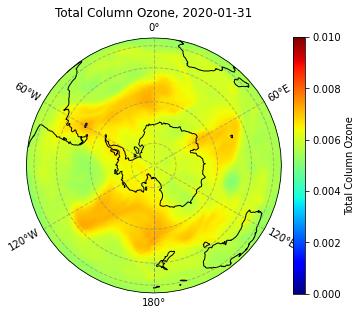

In [8]:
n = da.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(5, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_latitude=-90)) # Specify plot area & projection
    ax.coastlines(color='black') # Add coastlines
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Total Column Ozone, {str(da.time[i].values)[:-19]}', fontsize=12) # Set figure title, including date
    im = plt.pcolormesh(da.longitude.values-180., da.latitude.values, da[i,:,:], # Plot the data, iterating over time
                        cmap='jet', transform=ccrs.PlateCarree(), vmin=0, vmax=0.01)
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('Total Column Ozone') # Define the colourbar label
    plt.show() # Display the figure
    sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation

We will now inspect 2d plots of this data, but before we do so, we will reduce the time-series to a more manageable number of time-steps

In [9]:
da_short = da.loc['2019-08-12':'2019-11-19']

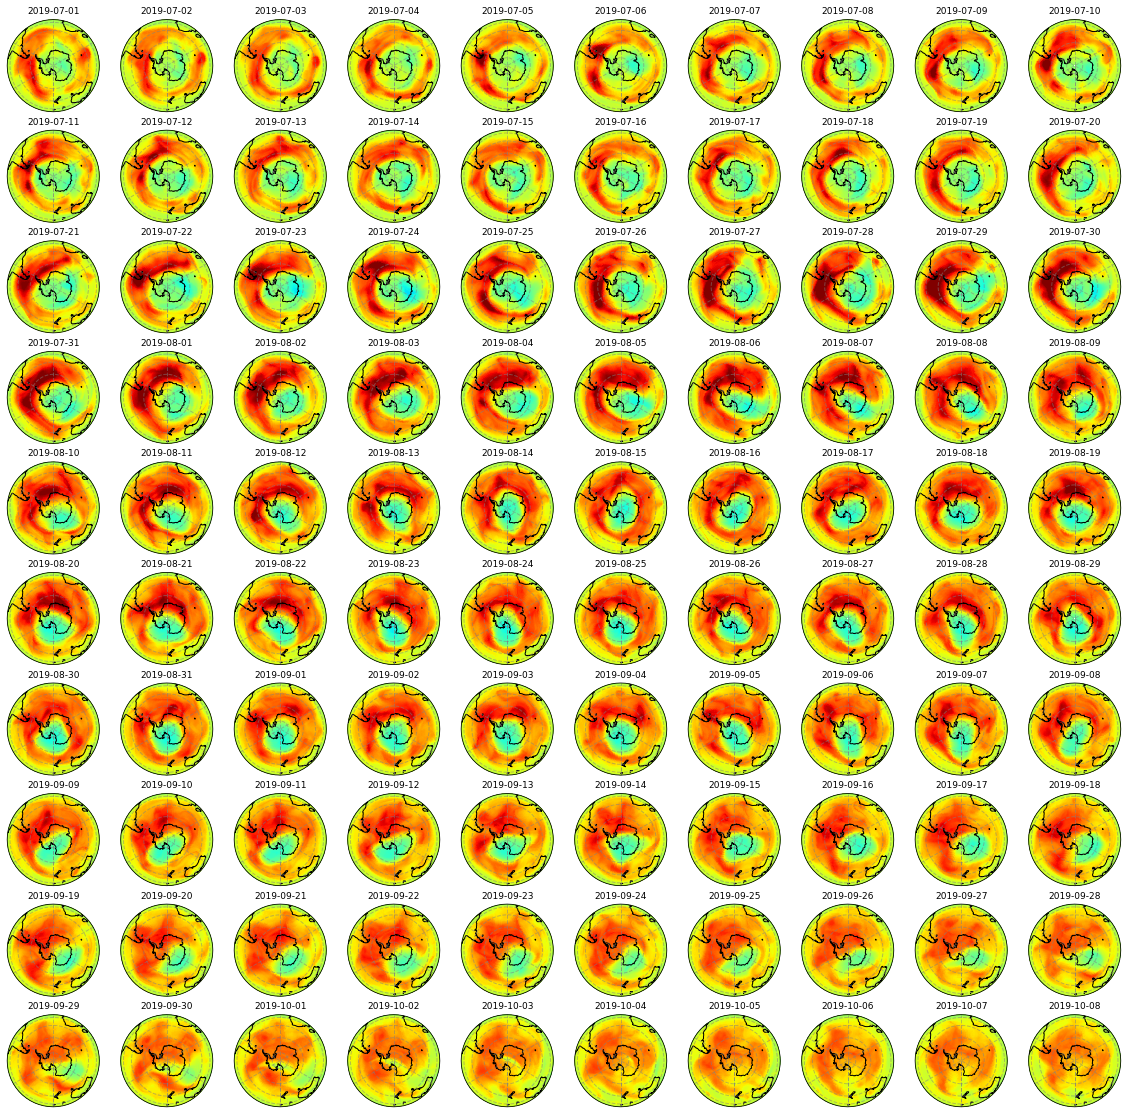

In [10]:
fig, axs = plt.subplots(10, 10, figsize = (20, 20), subplot_kw={'projection': ccrs.Orthographic(central_latitude=-90)})

for i in range(10):
    for j in range(10):
        axs[i,j].coastlines(color='black') # Add coastlines
        axs[i,j].gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
        axs[i,j].set_title(f'{str(da.time[((i*10)+j)].values)[:-19]}', fontsize=9) # Set figure title
        im = axs[i,j].pcolormesh(da_short.longitude.values-180., da_short.latitude.values, da_short[((i*10)+j),:,:],
                                transform = ccrs.PlateCarree(), cmap='jet', vmin=0, vmax=0.01)

plt.show() # Display the figure
fig.savefig('./ozone_plots.png') # Save the figure